In [2]:
# | default_exp classification.mlclassifer

In [28]:
import numpy as np

# | export
import pandas as pd
from pycaret.classification import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [31]:
df = pd.read_parquet("data/extracted_features.parquet")
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
df = df[
    [
        "adf_p",
        "approx_entropy",
        "kpss_p",
        "hurst_exponent",
        "dfa",
        "spectral_entropy",
        "acf_3",
        "acf_4",
        "acf_2",
        "cv",
        "acf_5",
        "stl_seasonal_std",
        "acf_6",
        "pacf_1",
        "acf_7",
        "acf_1",
        "acf_8",
        "svd_entropy",
        "longest_positive_run",
        "no_of_datapoints",
        "stl_trend_std",
        "skewness",
        "perm_entropy",
        "acf_9",
        "iqr",
        "num_peaks",
        "mad",
        "std",
        "medad",
        "fft_peak",
        "best_model",
    ]
]
df["granularity"] = df.index.map(lambda x: x[0])
# # Encode categorical labels
# le = LabelEncoder()
# m4_dataset["best_model"] = le.fit_transform(m4_dataset["best_model"])
# df.drop('wavelet_entropy',axis=1,inplace=True)
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# df['no_of_datapoints'] = scaler.fit_transform(df['no_of_datapoints'].values.reshape(-1, 1))

In [32]:
from pycaret.classification import setup

s = setup(
    data=df,  # Your dataframe
    target="best_model",  # Target variable
    session_id=42,  # Seed for reproducibility
    train_size=0.8,  # Train-test split ratio
    normalize=True,  # Apply feature normalization
    transformation=True,  # Apply feature transformation
    remove_multicollinearity=True,  # Remove multicollinear features
    multicollinearity_threshold=0.9,  # Correlation threshold
    feature_selection=True,  # Enable automatic feature selection
    remove_outliers=True,  # Remove outliers
    outliers_threshold=0.05,  # Outlier threshold
    log_experiment=False,  # Disable logging to MLflow
    experiment_name="classification_experiment",  # MLflow experiment name
    use_gpu=True,  # Use GPU if available
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that 

,Description,Value
0,Session id,42
1,Target,best_model
2,Target type,Multiclass
3,Target mapping,"AutoARIMA: 0, AutoETS: 1, AutoMFLES: 2, AutoRegressive: 3, AutoTBATS: 4, AutoTheta: 5, CES: 6"
4,Original data shape,"(47752, 32)"
5,Transformed data shape,"(45842, 7)"
6,Transformed train set shape,"(36291, 7)"
7,Transformed test set shape,"(9551, 7)"
8,Numeric features,30
9,Categorical features,1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that 

In [34]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.3394,0.6860,0.3394,0.3171,0.3169,0.2012,0.2044,3.2600
et,Extra Trees Classifier,0.3382,0.6846,0.3382,0.3167,0.3156,0.1993,0.2026,3.0520
lightgbm,Light Gradient Boosting Machine,0.3289,0.6809,0.3289,0.2990,0.2932,0.1831,0.1888,6.4030
catboost,CatBoost Classifier,0.3247,0.6824,0.3247,0.2965,0.2988,0.1828,0.1860,5.4120
xgboost,Extreme Gradient Boosting,0.3219,0.6769,0.3219,0.2933,0.2926,0.1773,0.1813,3.9750
gbc,Gradient Boosting Classifier,0.3211,0.0000,0.3211,0.2841,0.2754,0.1694,0.1772,36.4160
ada,Ada Boost Classifier,0.3055,0.0000,0.3055,0.2668,0.2536,0.1478,0.1568,3.7410
qda,Quadratic Discriminant Analysis,0.3042,0.0000,0.3042,0.2637,0.2499,0.1503,0.1590,2.6980
lr,Logistic Regression,0.3024,0.0000,0.3024,0.2321,0.2392,0.1430,0.1516,2.8490
lda,Linear Discriminant Analysis,0.3023,0.0000,0.3023,0.2298,0.2388,0.1430,0.1518,2.9030


In [35]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

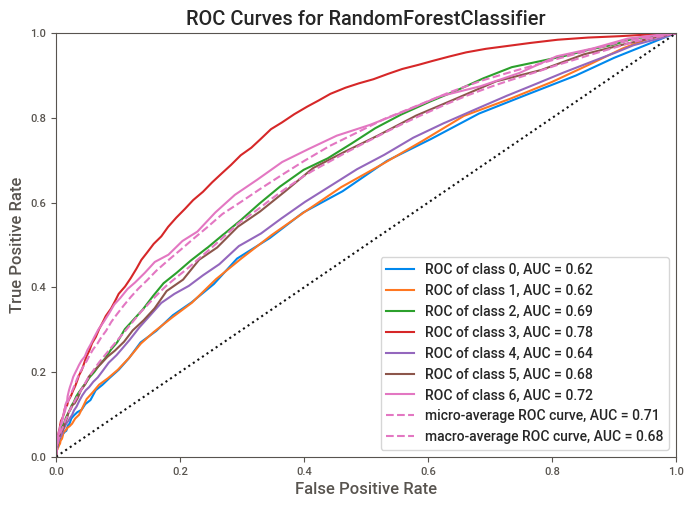

In [36]:
plot_model(best, plot="auc")

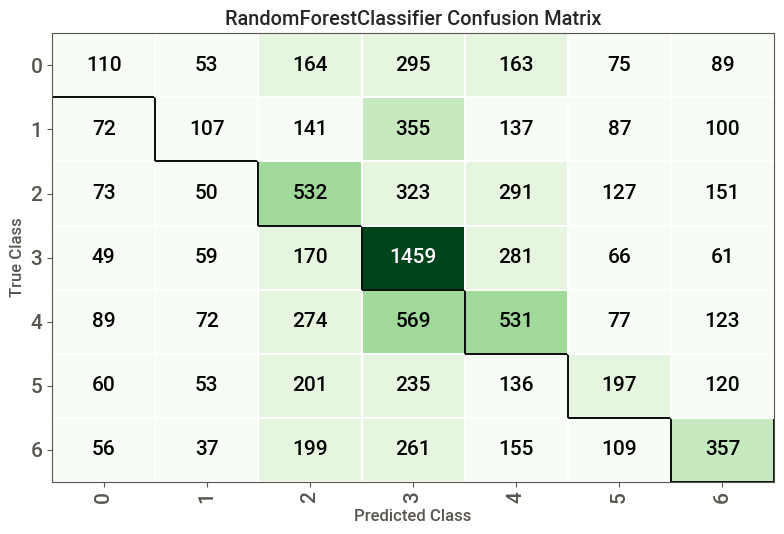

In [37]:
plot_model(best, plot="confusion_matrix")

In [41]:
s.automl

<bound method ClassificationExperiment.automl of <pycaret.classification.oop.ClassificationExperiment object at 0x7557a254bd10>>